In [1]:
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle

import themachinethatgoesping as theping

## Initialize file handler 

- fh will be the file handler that takes care of interacting with the data from all files you feed it
- Files are expected to be .all and/or .wcd for the KongsbergAllFileHandler, there is currently no validity checking for the file types
- A 'cache' folder will be created which includes some MB of data that is 'expensive' to read from the raw data. Passing 'cache_files' to the file handler will take care of the caching automatically. 'cache_files' is a dictionary with a cache file path for each .all or .wcd file

In [2]:
!ls dotall

ls: cannot access 'dotall': No such file or directory


In [3]:
files = theping.echosounders.index_functions.find_files('.','.all')
files = theping.echosounders.index_functions.find_files(
    '/home/users/data/no_backup/GEOMAR/Meteor-M143/MBES/M143_EM710_raw/',['.all','.wcd']
)
files = pickle.load(open('files.pcl','rb'))

# files = theping.echosounders.index_functions.find_files(
#     '/home/data/test_data/Egmont_Key/dotall/',['.all','.wcd']
# )

# files = theping.echosounders.index_functions.find_files(
#     '/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/TURBEAMS_December_2023_25/',['.all','.wcd']
# )

    
# files = theping.echosounders.index_functions.find_files(
#     '/home/ssd/src/themachinethatgoesping/tutorials/unittest_data/',['.all','.wcd']
# )
# files = theping.echosounders.index_functions.find_files(
#     '/home/ssd/src/themachinethatgoesping/tutorials/unittest_data/',['.wcd']
# )

cache_files = theping.echosounders.index_functions.get_index_paths(files)

fh = theping.echosounders.kongsbergall.KongsbergAllFileHandler(files,cache_files,init=True)

Found 2 files
Found 435 files
indexing files ⢀ 99% :00s<00m:00s] [Found: 2420926 datagrams in 180 files (26298MB)]                                                 
Initializing ping interface ⠂ 98% :05s<00m:00s] [Done]                                                                             


# filter pings

In [4]:
all_pings = theping.pingprocessing.filter_pings.by_features(fh.get_pings(), ['watercolumn.amplitudes'])

In [5]:
pingviewer = theping.pingprocessing.widgets.WCIViewer(all_pings)

## Get a navigation overview

Just a helper function to plott the navigation

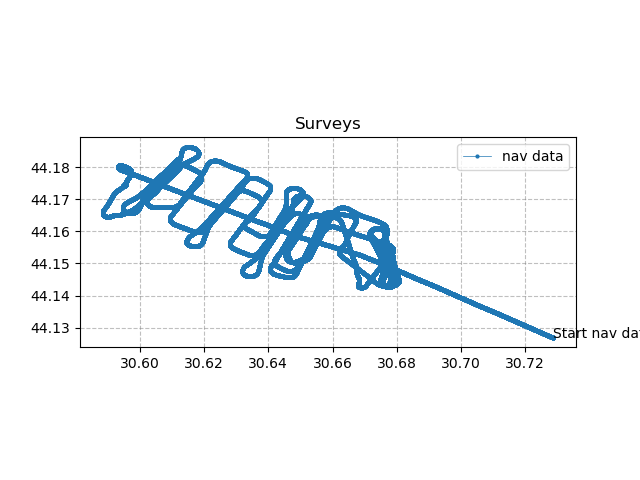

In [11]:
# helper function to create a figure, it justs call matplotlib.fig and matplotlib.subplots 
# and it makes sure the figure is closed in case it exists already
# additionally, it gives you the option to plot a background geo tiff using rasterio
fig_nav, ax_nav = theping.pingprocessing.overview.nav_plot.create_figure(
    'Surveys',                                                                      
    #background_image_path='path to tiff' #if you have nice geotiff with bathy for your area, add the path here
)

# a class to extract some basic ping statistics
overview = theping.pingprocessing.overview.get_ping_overview(all_pings)

#plot the navgigastion data,
#automatically downsample the points to max 100000 points
overview.plot_navigation(ax_nav, label='nav data')

ax_nav.legend()

In [12]:
import importlib
importlib.reload(theping.pingprocessing.watercolumn.helper)
importlib.reload(theping.pingprocessing.widgets)

<module 'themachinethatgoesping.pingprocessing.widgets' from '/ssd/src/themachinethatgoesping/themachinethatgoesping/subprojects/meta/..//pingprocessing/python/themachinethatgoesping/pingprocessing/widgets/__init__.py'>

In [14]:
# select pings
pings = all_pings

pss = theping.echosounders.pingtools.PingSampleSelector()
#pss.select_beam_range_by_angles(-3,3)

In [15]:
#view the data

viewer = theping.pingprocessing.widgets.WCIViewer(pings, ping_sample_selector = pss)

In [15]:
#view the data

viewer = theping.pingprocessing.widgets.WCIViewer(pings,name='2')

In [8]:
stack=300
step = int(stack / 3) if int(stack / 3) >0 else 1

viewer.w_mp_cores.value=8
viewer.w_stack.value = stack
viewer.w_index.set_trait('step', step)
viewer.w_stack_step.value = int(stack / 30) if int(stack / 20) >0 else 1

print(step)

100


In [9]:
import time
start = viewer.w_index.value
end   = start + 10000

t1=time.time()
for pn in range(start,end+1,step):
    viewer.w_index.value = pn
t2=time.time()
print((t2-t1))
print((t2-t1)/(end-start))
print((end-start)/(t2-t1))

KeyboardInterrupt: 

## Create an echogram

In [17]:
#build the echogram
pings = all_pings

#a beam selector object, we will only use the beams between +-3° (downward looking beams)
pss = theping.echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(-90,90,int(256/25))
pss.select_minslant_range_percent(None,105)

echodata = theping.pingprocessing.watercolumn.echograms.EchogramBuilder.from_pings(pings,pss=pss)

  5%|5         | 7439/142623 [00:01<00:18, 7438.35it/s]

In [19]:
echodata.set_x_axis_date_time(max_steps=20000)
echodata.set_y_axis_depth(max_samples=1000)
echoviewer = theping.pingprocessing.widgets.EchogramViewer(echodata)

In [24]:
from pytimeparse2 import parse as timeparse
# get deltaT from figure
xmin,xmax = echoviewer.axes[0].get_xlim()
deltaT = mdates.num2date(xmax) - mdates.num2date(xmin)

# or set deltaT manually
#deltaT = timeparse('25min',as_timedelta=True)

overlap = timeparse('5min', as_timedelta=True)

print(deltaT, overlap)
print()
imagefolder = f'images/sb_timeblocks-{deltaT}'
print(f'imagefolder: "{imagefolder}"')

0:10:07.747901 relativedelta(minutes=+5)

imagefolder: "images/sb_timeblocks-0:10:07.747901"


In [25]:
import ipywidgets
import matplotlib.dates as mdates
from pytimeparse2 import parse as timeparse

bleft = ipywidgets.Button(description="Left")
bright = ipywidgets.Button(description="right")
navbox = ipywidgets.HBox([bleft,bright])

def move(e=0):
    echoviewer.output.clear_output()
    with echoviewer.output:
        print(e)
    
        xmin,xmax = echoviewer.axes[0].get_xlim()
        t1 = mdates.num2date(xmin)
        t2 = mdates.num2date(xmax)
    
        t2 = t1 + 2* deltaT + overlap
        t1 = t1 + deltaT - overlap

        print(t1,t2)
        echoviewer.axes[0].set_xlim(t1,t2)
        echoviewer.show_background_zoom()
    

bleft.on_click(move)
bright.on_click(move)

echodata.set_x_axis_date_time(max_steps=4000)
echodata.set_y_axis_depth(max_samples=1000)
echoviewer.show()
navbox

Output()

In [29]:
from pytimeparse2 import parse as timeparse
import os

!rm -rf images_time_blocks
os.makedirs(imagefolder,exist_ok=True)

for k,v in tqdm(theping.pingprocessing.split_pings.into_time_blocks(pings,deltaT,full_hour_base=True, overlap1 = overlap).items()):
    t1 = k
    t2 = k+deltaT +overlap
    echoviewer.axes[0].set_xlim(t1,t2)
    echoviewer.show_background_zoom()
    name = f'{t1}'.replace(' ','_')+'.png'

    print(name, end='\r')
    echoviewer.fig.savefig(os.path.join(imagefolder,name))

  0%|          | 0/122 [00:00<?, ?it/s]